<a href="https://colab.research.google.com/github/jackgurae/DS_project/blob/main/Colab_Portfolio/Monte_Carlo_Multi_assets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from scipy import stats

In [ ]:
## Plain Vanilla Call
def blackScholes_py(S_0, strike, time_to_expiry, implied_vol, risk_free_rate):
    S = S_0
    K = strike
    dt = time_to_expiry
    sigma = implied_vol
    r = risk_free_rate
    Phi = stats.norm.cdf
    d_1 = (np.log(S_0 / K) + (r+sigma**2/2)*dt) / (sigma*np.sqrt(dt))
    d_2 = d_1 - sigma*np.sqrt(dt)
    return S*Phi(d_1) - K*np.exp(-r*dt)*Phi(d_2)

In [ ]:
# %%timeit -n 10
S_0 = 102.5
strike =80.0
time_to_expiry = 0.25
implied_vol = 0.3
risk_free_rate = 0.03
barrier = 1.0
trials = 100000
steps =100
price_np = blackScholes_py(S_0, strike, time_to_expiry, implied_vol, risk_free_rate)
print(price_np)

23.343362555184484


In [ ]:
def analytical_downOut_py(S_0, strike, time_to_expiry, implied_vol, risk_free_rate, barrier):
    S = S_0
    K = strike
    dt = time_to_expiry
    sigma = implied_vol
    r = risk_free_rate
    alpha = 0.5 - r/sigma**2
    B = barrier
    Phi = stats.norm.cdf
    d_1 = (np.log(S_0 / K) + (r+sigma**2/2)*dt) / (sigma*np.sqrt(dt))
    d_2 = d_1 - sigma*np.sqrt(dt)
    bs = S*Phi(d_1) - K*np.exp(-r*dt)*Phi(d_2)
    d_1a = (np.log(B**2 / (S*K)) + (r+sigma**2/2)*dt) / (sigma*np.sqrt(dt))
    d_2a = d_1a - sigma*np.sqrt(dt)
    reflection = (S/B)**(1-r/sigma**2) * ((B**2/S)*Phi(d_1a) - K*np.exp(-r*dt)*Phi(d_2a))
    return max(bs - reflection,0)

In [ ]:
doc_analytical = analytical_downOut_py(S_0, strike, time_to_expiry, implied_vol, risk_free_rate, barrier)
print(doc_analytical)

23.343362555184484


In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
cuda0 = torch.device('cuda:0')

1
Tesla K80


In [ ]:
def monte_carlo_down_out_py(S_0, strike, time_to_expiry, implied_vol, risk_free_rate, barrier, steps, trials):
    stdnorm_random_variates = np.random.randn(trials, steps)
    S = S_0
    K = strike
    dt = time_to_expiry / stdnorm_random_variates.shape[1]
    sigma = implied_vol
    r = risk_free_rate
    B = barrier
    # See Advanced Monte Carlo methods for barrier and related exotic options by Emmanuel Gobet
    B_shift = B*np.exp(0.5826*sigma*np.sqrt(dt))
    S_T = S * np.cumprod(np.exp((r-sigma**2/2)*dt+sigma*np.sqrt(dt)*stdnorm_random_variates), axis=1)
    non_touch = (np.min(S_T, axis=1) > B_shift)*1
    call_payout = np.maximum(S_T[:,-1] - K, 0)
    npv = np.mean(non_touch * call_payout)
    return np.exp(-time_to_expiry*r)*npv

In [ ]:
# %%timeit -n 10
dop_mc = monte_carlo_down_out_py(S_0, strike, time_to_expiry, implied_vol, risk_free_rate, barrier, steps, trials)
print(dop_mc)

23.26397736051504


In [ ]:
def monte_carlo_down_out_torch_cuda(S_0, strike, time_to_expiry, implied_vol, risk_free_rate, barrier, steps, trials):
    stdnorm_random_variates = torch.cuda.FloatTensor(trials, steps).normal_()
    S = S_0
    K = strike
    dt = time_to_expiry / stdnorm_random_variates.shape[1]
    sigma = implied_vol
    r = risk_free_rate
    B = barrier
    # B_shift = B*torch.exp(0.5826*sigma*torch.sqrt(dt))
    B_shift = B
    S_T = S * torch.cumprod(torch.exp((r-sigma**2/2)*dt+sigma*torch.sqrt(dt)*stdnorm_random_variates), dim=1)
    non_touch = torch.min(S_T, dim=1)[0] > B_shift
    non_touch = non_touch.type(torch.cuda.FloatTensor)
    call_payout = S_T[:,-1] - K
    call_payout[call_payout<0]=0
    doc_payout = torch.mean(non_touch * call_payout)
    return torch.exp(-time_to_expiry*r)*doc_payout, non_touch

In [ ]:
# %%timeit -n 10
t_S_0 = torch.tensor([S_0], requires_grad=True, device='cuda')
t_strike = torch.tensor([strike], requires_grad=True, device='cuda')
t_time_to_expiry = torch.tensor([time_to_expiry], requires_grad=True, device='cuda')
t_implied_vol = torch.tensor([implied_vol], requires_grad=True, device='cuda')
t_risk_free_rate = torch.tensor([risk_free_rate], requires_grad=True, device='cuda')
t_barrier = torch.tensor([barrier], requires_grad=True, device='cuda')
doc_mc_torch, non_touch = monte_carlo_down_out_torch_cuda(t_S_0, t_strike, t_time_to_expiry, t_implied_vol, t_risk_free_rate, t_barrier, steps, trials)
print(doc_mc_torch)
doc_mc_torch[0].backward()


tensor([23.3795], device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
delta = t_S_0.grad
delta

tensor([0.9621], device='cuda:0')

In [ ]:
# def simulate_correlated_w(opt1, opt2, opt3, corr):
#   w1 = torch.cuda.FloatTensor(trials, steps).normal_()
#   w2 = torch.cuda.FloatTensor(trials, steps).normal_()
#   w3 = torch.cuda.FloatTensor(trials, steps).normal_()
#   L = torch.cholesky(corr)

In [ ]:
# # %%timeit -n 10
# w = torch.cuda.FloatTensor(trials, steps, 3).normal_()
# w_cpu = w.to('cpu')

In [ ]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 8.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import yfinance as yf
s1 = "PTT.BK"
s2 = "PTTGC.BK"
s3 = "KCE.BK"
prices = yf.download("{}, {}, {}".format(s1, s2, s3), start="2021-01-01", end="2021-01-31")['Close']
returns = prices.pct_change().dropna()
cov_thai = returns.cov()*252
cov_thai

[*********************100%***********************]  3 of 3 completed


,KCE.BK,PTT.BK,PTTGC.BK
KCE.BK,0.329902,0.023370,-0.001834
PTT.BK,0.023370,0.062930,0.027122
PTTGC.BK,-0.001834,0.027122,0.088587


In [ ]:
class OptionSpec:
  def __init__(self, s0, k, implied_vol, barrier, ki, time_to_expiry, risk_free_rate):
    self.s0 = torch.tensor([s0], requires_grad=True, device='cuda')
    self.k = torch.tensor([k], requires_grad=True, device='cuda')
    self.implied_vol = torch.tensor([implied_vol], requires_grad=True, device='cuda')
    self.barrier = torch.tensor([barrier], device='cuda')
    self.ki = torch.tensor([ki], device='cuda')
    self.time_to_expiry =  torch.tensor([time_to_expiry], requires_grad=True, device='cuda')
    self.risk_free_rate = torch.tensor([risk_free_rate], requires_grad=True, device='cuda')

In [ ]:
trials = 100000
steps =100
time_to_expiry = 0.5
risk_free_rate = 0.03

S_1 = prices.iloc[-1,0]
strike_1 = S_1* 0.9
implied_vol_1 = 0.3
barrier_1 = S_1 * 1.10
ki_1 = S_1 * 0.7
opt1 = OptionSpec(S_1, strike_1, implied_vol_1, barrier_1, ki_1, time_to_expiry, risk_free_rate)

S_2 = prices.iloc[-1,1]
strike_2 = S_2* 0.9
implied_vol_2 = 0.3
barrier_2 = S_2 * 1.10
ki_2 = S_2 * 0.7
opt2 = OptionSpec(S_2, strike_2, implied_vol_2, barrier_2,ki_2, time_to_expiry, risk_free_rate)

S_3 = prices.iloc[-1,2]
strike_3 = S_3* 0.9
implied_vol_3 = 0.3
barrier_3 = S_3* 1.10
ki_3 = S_3 * 0.7
opt3 = OptionSpec(S_3, strike_3, implied_vol_3, barrier_3,ki_3, time_to_expiry, risk_free_rate)

# corr = np.array([[1.0, 0.8, -0.3], [0.8, 1.0, 0.2], [-0.3, 0.2, 1.0]])
# corr_torch = torch.from_numpy(corr).float()


In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal
mean = torch.Tensor([0, 0, 0])
cov_tensor = torch.from_numpy(pd.DataFrame.to_numpy(cov_thai)).to(dtype=torch.float32)
# distrib = MultivariateNormal(loc=mean, covariance_matrix=cov_tensor)
dist2 = np.random.multivariate_normal(mean, cov_tensor / 252, [1000,250])
dist2 = torch.from_numpy(dist2).to('cuda')


In [ ]:
dist2[:,:,0].shape

torch.Size([1000, 250])

In [ ]:
dt = torch.tensor(time_to_expiry / steps)
# S_1 = opt1.s0 * torch.cumprod(torch.exp((opt1.risk_free_rate-opt1.implied_vol**2/2)*dt+opt1.implied_vol*torch.sqrt(dt)*dist2[:,0]), dim=0)
# S_2 = opt2.s0 * torch.cumprod(torch.exp((opt2.risk_free_rate-opt2.implied_vol**2/2)*dt+opt2.implied_vol*torch.sqrt(dt)*dist2[:,1]), dim=0)
# S_3 = opt3.s0 * torch.cumprod(torch.exp((opt3.risk_free_rate-opt3.implied_vol**2/2)*dt+opt3.implied_vol*torch.sqrt(dt)*dist2[:,2]), dim=0)
S_1 = opt1.s0 * torch.cumprod(torch.exp(dist2[:,:,0]), dim=1)
S_2 = opt2.s0 * torch.cumprod(torch.exp(dist2[:,:,1]), dim=1)
S_3 = opt3.s0 * torch.cumprod(torch.exp(dist2[:,:,2]), dim=1)


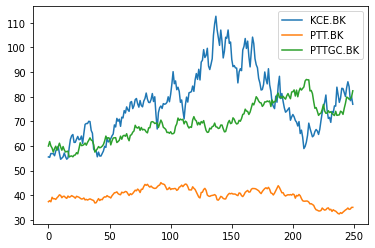

In [ ]:
torch.Tensor.ndim = property(lambda self: len(self.shape)) 
S_1_np = S_1.cpu().detach().numpy()[1]
S_2_np = S_2.cpu().detach().numpy()[1]
S_3_np = S_3.cpu().detach().numpy()[1]
plot_price = pd.DataFrame({prices.columns[0]:S_1_np, prices.columns[1]:S_2_np, prices.columns[2]:S_3_np})
# plt.plot(plot_price)
plot_price.plot()

In [ ]:
returns_sim = plot_price.pct_change().dropna()
cov_sim = returns_sim.cov() * 252
cov_sim

,KCE.BK,PTT.BK,PTTGC.BK
KCE.BK,0.394801,0.031438,0.005814
PTT.BK,0.031438,0.062943,0.028369
PTTGC.BK,0.005814,0.028369,0.088186


In [ ]:
samp2 = distrib.sample([100, 1000])
samp2 = samp2.to('cuda')
samp2.shape

NameError: ignored

In [ ]:
dt = torch.tensor(time_to_expiry / steps)
# dt.shape
# dt = time_to_expiry /steps
S_1_sim = opt1.s0 * torch.cumprod(torch.exp((opt1.risk_free_rate-opt1.implied_vol**2/2)*dt+opt1.implied_vol*torch.sqrt(dt)*samp2[:,:,0]), dim=0)
S_2_sim = opt2.s0 * torch.cumprod(torch.exp((opt2.risk_free_rate-opt2.implied_vol**2/2)*dt+opt2.implied_vol*torch.sqrt(dt)*samp2[:,:,1]), dim=0)
S_3_sim = opt3.s0 * torch.cumprod(torch.exp((opt3.risk_free_rate-opt3.implied_vol**2/2)*dt+opt3.implied_vol*torch.sqrt(dt)*samp2[:,:,2]), dim=0)


NameError: ignored

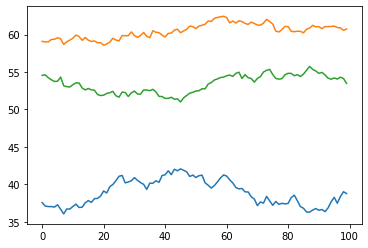

In [ ]:
torch.Tensor.ndim = property(lambda self: len(self.shape)) 
tt = 0
S_1_np = S_1_sim.cpu().detach().numpy()[:,tt]
S_2_np = S_2_sim.cpu().detach().numpy()[:,tt]
S_3_np = S_3_sim.cpu().detach().numpy()[:,tt]

plt.plot(S_1_np)
plt.plot(S_2_np)
plt.plot(S_3_np)

In [ ]:
prices_sim = pd.DataFrame({s1: S_1_np, s2:S_2_np, s3:S_3_np})
returns_sim = prices_sim.pct_change().dropna()
cov_sim = returns_sim.cov() * 252
cov_sim

,PTT.BK,PTTGC.BK,KCE.BK
PTT.BK,0.038394,0.001259,-0.001394
PTTGC.BK,0.001259,0.007346,0.003720
KCE.BK,-0.001394,0.003720,0.011219


In [ ]:
def autocallable_torch_cuda(opt1, opt2, opt3, time_to_expiry, barrier, steps, trials):
    S = S_0
  
    dt = time_to_expiry / torch.tensor([steps], device='cuda')
    sigma = implied_vol
    r = opt1.risk_free_rate
    B = barrier
    # See Advanced Monte Carlo methods for barrier and related exotic options by Emmanuel Gobet
    # B_shift = B*torch.exp(0.5826*sigma*torch.sqrt(dt))
    B_opt1 = opt1.barrier
    mean = torch.Tensor([0, 0, 0])
    cov_tensor = torch.from_numpy(pd.DataFrame.to_numpy(cov_thai)).to(dtype=torch.float32)
    # distrib = MultivariateNormal(loc=mean, covariance_matrix=cov_tensor)
    w = np.random.multivariate_normal(mean, cov_tensor / 252, [trials, steps])
    w = torch.from_numpy(w).to('cuda')
    S1 = opt1.s0 * torch.cumprod(torch.exp(w[:,:,0]), dim=1)
    S2 = opt2.s0 * torch.cumprod(torch.exp(w[:,:,1]), dim=1)
    S3 = opt3.s0 * torch.cumprod(torch.exp(w[:,:,2]), dim=1)
    
    # check if KO
    KO_touch_ob1_opt1 = torch.any(S1[:,:20] > opt1.barrier, dim=1)
    KO_touch_ob1_opt2 = torch.any(S2[:,:20] > opt2.barrier, dim=1)
    KO_touch_ob1_opt3 = torch.any(S3[:,:20] > opt3.barrier, dim=1)
    KO_touch_ob1 = torch.logical_and(torch.logical_and(KO_touch_ob1_opt1, KO_touch_ob1_opt2), KO_touch_ob1_opt3)
    ac_payout_ko = 20 * KO_touch_ob1 + 100
    
    # chek if KI DIP  
    KI_touch_opt1 = torch.min(S1, dim=1)[0] < B_opt1
    KI_touch_opt1 = KI_touch_opt1.type(torch.cuda.FloatTensor)
    dip1_payout = opt1.k - S1[:,-1]
    dip1_payout[dip1_payout<0]=0
    dip1_payout = dip1_payout * -1
    
    S1_T_return = S1[:,-1] / S1[:,0] - 1
    S2_T_return = S1[:,-1] / S1[:,0] - 1
    S3_T_return = S1[:,-1] / S1[:,0] - 1
    dip_payout = torch.minimum(torch.minimum(S1_T_return, S2_T_return), S3_T_return)
    ac_payout = KI_touch_opt1 * dip_payout * torch.logical_not(KO_touch_ob1) + ac_payout_ko
    ac_payout_mean = torch.mean(ac_payout)
    return torch.exp(-time_to_expiry*r)*ac_payout_mean, non_touch, S1, ac_payout

In [ ]:
# %%timeit -n 10
ac_price, non_touch, stock1, ac_payout = autocallable_torch_cuda(opt1, opt2, opt3, time_to_expiry, barrier, steps, trials)

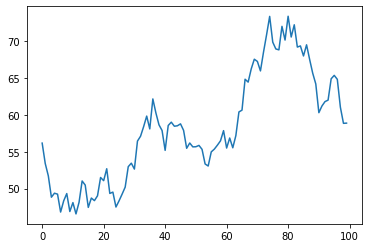

In [ ]:
plt.plot(stock1[3,:].cpu().detach().numpy())

In [ ]:
ac_price

tensor([99.1494], device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
a = torch.tensor([50, 30, 60])
KO = a > 75
torch.any(KO).item()

False

In [ ]:
f = torch.tensor([True, False, False])
g = torch.logical_not(f)
g

tensor([False,  True,  True])

[`Monte Carlo Simulation Engine in Python`](https://medium.com/fintechexplained/monte-carlo-simulation-engine-in-python-a1fa5043c613)

[`Fast Monte Carlo Pricing and Greeks for Barrier Options`](https://ipythonquant.wordpress.com/2018/11/18/fast-monte-carlo-pricing-and-greeks-for-barrier-options-using-gpu-computing-on-google-cloud-platform-in-python/)